# --------------------------------------------------------------
# Coursework: ECON 4999V Applied Machine Learning for Economic and Financial Analysis - Fall 2022
#University: Hong Kong University of Science and Technology
#Project Title: Bankruptcy Statistics Analysis & Prediction

# Description:
#This Python notebook is part of the coursework for the Applied Machine Learning course in Fall 2022.
#The project focuses on analyzing bankruptcy statistics using machine learning techniques.
#The team (4 people in total) collaboratively worked on different aspects of the project.
#My specific contribution to this project is the Data Visualization & Analysis part, which is included in this file.
#The code presented here demonstrates various data visualization techniques using Pandas, Matplotlib, and Seaborn to gain insights
#and present key patterns in the bankruptcy statistics dataset.
#Please note that the model building and prediction analysis, performed by other group members, are not shown in this file.
#
#Libraries Used: Pandas, Matplotlib, Seaborn
#
# --------------------------------------------------------------



# Import libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from scipy.stats import uniform

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# Import Data

In [2]:
dataset = pd.read_csv("bankruptcy_data.csv", header = 0, parse_dates=False)
pd.set_option('display.max_columns', None)

dataset.columns = dataset.columns.str.strip() # Remove the leading space in the column names
dataset.head()

bankrupt = dataset[dataset['Bankrupt?'] == 1]
non_bankrupt = dataset[dataset['Bankrupt?'] == 0]

# Data Visualisation and Analysis

In [3]:
# Helper function for generating list of combinations of features
def get_combinations(features):
  combinations = []
  for i in range(0, len(features)):
      for j in range(i+1, len(features)):
          combinations.append([features[i], features[j]])
  return combinations

# Helper function for plotting the correlation between two features
def scatterplot(bankrupt, non_bankrupt, features):
  combinations = get_combinations(features)
  plt.figure(figsize=(20, 6))
  nrows = int(np.ceil(len(combinations)/3))

  for combination in combinations:
    plt.subplot(nrows, 3, combinations.index(combination)+1)
    sns.scatterplot(x=bankrupt[combination[0]], y=bankrupt[combination[1]], data=bankrupt)
    sns.scatterplot(x=non_bankrupt[combination[0]], y=non_bankrupt[combination[1]], data=non_bankrupt)
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='k')
  plt.legend(['Bankrupt', 'Non-Bankrupt'])
  plt.show()

# Helper function for showing correlation table
def correlation_table(data, features):
  features.append('Bankrupt?')
  corr = dataset[features].corr()
  display(corr.style.background_gradient(cmap='coolwarm'))

# Helper function for finding top 10 features correlated with a feature
def top_10_corr(data, feature):
  corr = data.corr()
  return corr[feature].sort_values(ascending=False).head(11)

# Helper function for plotting the distribution of a feature for bankrupt and non-bankrupt companies in the same plot
def plot_distribution(bankrupt, non_bankrupt, feature):
  plt.figure(figsize=(20, 6))
  sns.distplot(bankrupt[feature], label='Bankrupt')
  sns.distplot(non_bankrupt[feature], label='Non-Bankrupt')
  plt.legend()
  plt.show()

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

The data does not contain any missing values. Also, all variables are already in numeric format.

In [5]:
# Initial data exploration
dataset.describe().min()

Bankrupt?                                                  0.0
ROA(C) before interest and depreciation before interest    0.0
ROA(A) before interest and % after tax                     0.0
ROA(B) before interest and depreciation after tax          0.0
Operating Gross Margin                                     0.0
                                                          ... 
Liability to Equity                                        0.0
Degree of Financial Leverage (DFL)                         0.0
Interest Coverage Ratio (Interest expense to EBIT)         0.0
Net Income Flag                                            0.0
Equity to Liability                                        0.0
Length: 96, dtype: float64

Percentage of bankrupt companies:  220  /  6819  =  3.23 %
Percentage of non-bankrupt companies:  6599  /  6819  =  96.77 %


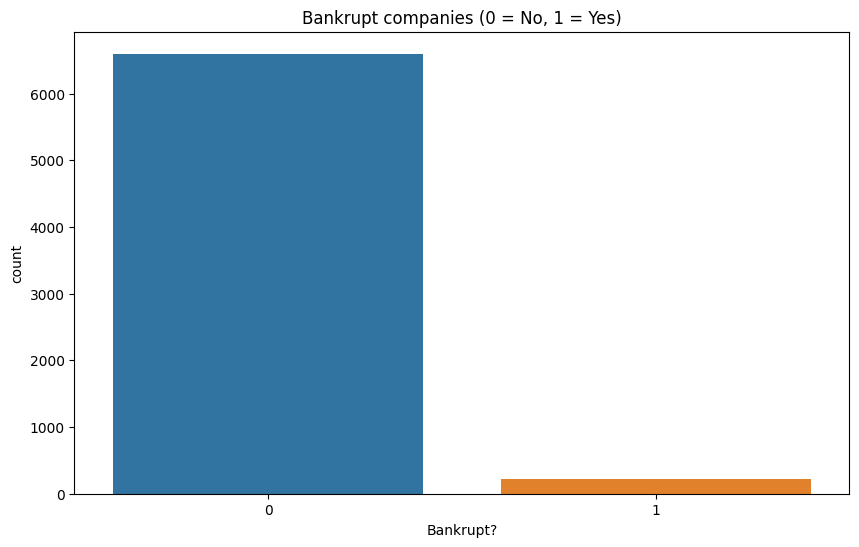

In [6]:
# Plot the percentage of bankrupt companies
print("Percentage of bankrupt companies: ", len(bankrupt) , " / ", len(dataset), " = ", round(len(bankrupt)/len(dataset)*100, 2), "%")
print("Percentage of non-bankrupt companies: ", len(non_bankrupt) , " / ", len(dataset), " = ", round(len(non_bankrupt)/len(dataset)*100, 2), "%")
plt.figure(figsize=(10, 6))
sns.countplot(x='Bankrupt?', data=dataset)
plt.title('Bankrupt companies (0 = No, 1 = Yes)')
plt.show()

As the percentage of bankrupt companies is significantly lower than the percentage of non-bankrupt companies, there is severe class imbalance problem in the dataset. We will need to oversample the training set later to improve the performance of machine learning models.

In [7]:
# Describle Net Income Flag Column
dataset['Net Income Flag'].value_counts()

1    6819
Name: Net Income Flag, dtype: int64

We can see that the variable "Net Income Flag" has only one value, so it should be dropped during data preprocessing.

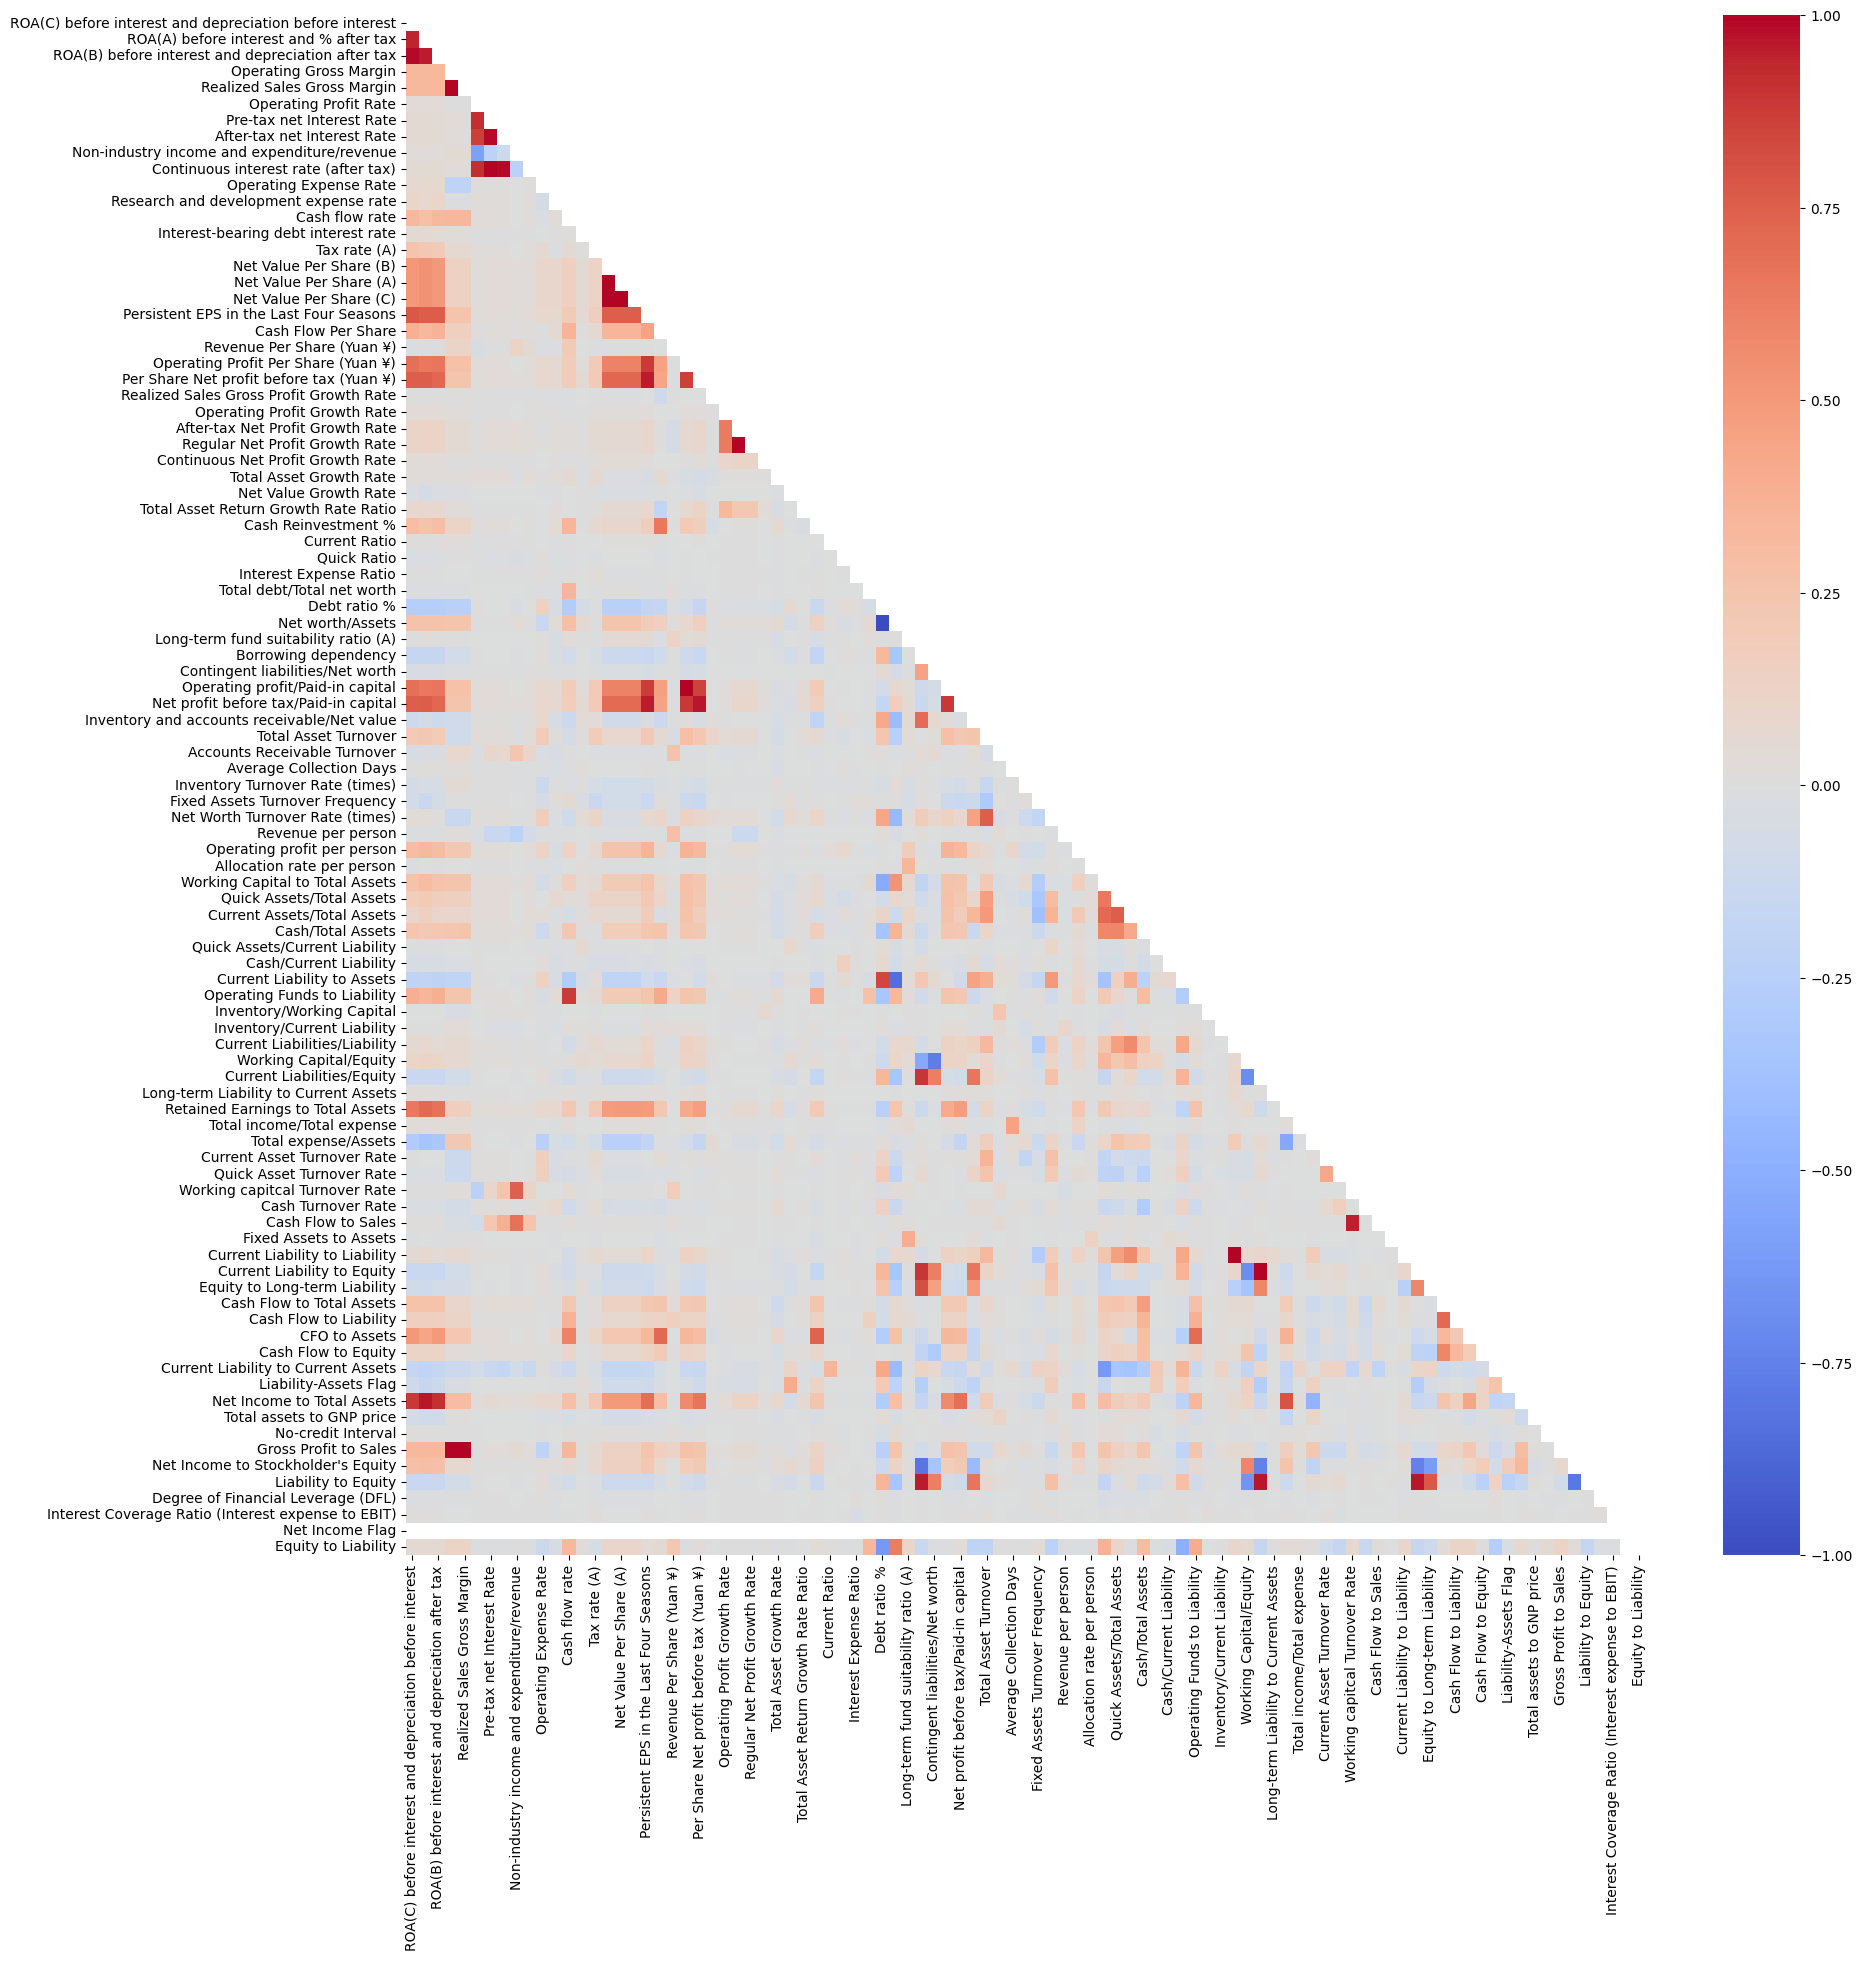

In [8]:
features = dataset.drop(['Bankrupt?'], axis=1)

# Find the correlation between the features
# Only display the lower triangle of the correlation matrix
# Remove the diagonal and duplicate values
plt.figure(figsize=(20, 20))
sns.heatmap(features.corr(), annot=False, cmap='coolwarm', mask=np.triu(features.corr()))
plt.show()

There are many variables with a high correlation. To improve computational efficiency and reduce the risk of overfitting, we can drop some of the features. Also, some models are sensitive to multicollinearity, so removing highly correlated features can improve the model.

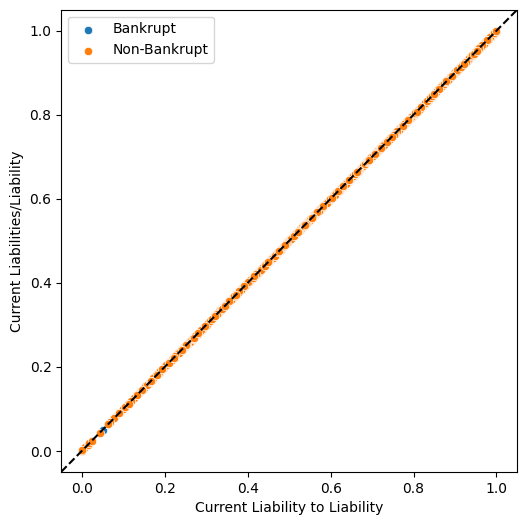

,Current Liability to Liability,Current Liabilities/Liability,Bankrupt?
Current Liability to Liability,1.000000,1.000000,-0.020809
Current Liabilities/Liability,1.000000,1.000000,-0.020809
Bankrupt?,-0.020809,-0.020809,1.000000


In [9]:
# 'Current Liability to Liability', 'Current Liabilities/Liability'
features = ['Current Liability to Liability', 'Current Liabilities/Liability']
scatterplot(bankrupt, non_bankrupt, features)
correlation_table(dataset, features)

Current Liability to Liability is identical to Current Liabilities/Liability. We will keep Current Liability to Liability and drop the other one

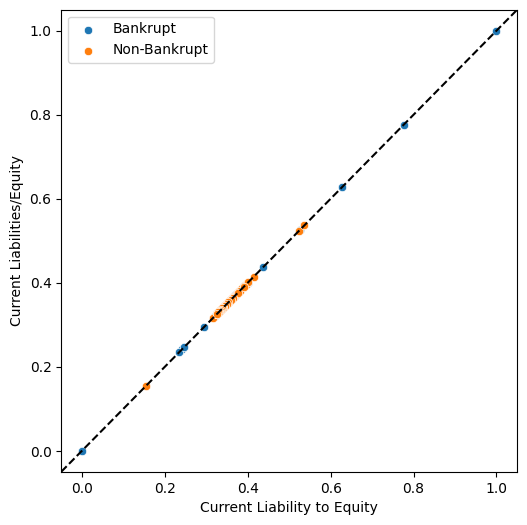

,Current Liability to Equity,Current Liabilities/Equity,Bankrupt?
Current Liability to Equity,1.000000,1.000000,0.153828
Current Liabilities/Equity,1.000000,1.000000,0.153828
Bankrupt?,0.153828,0.153828,1.000000


In [10]:
# 'Current Liability to Equity', 'Current Liabilities/Equity'
features = ['Current Liability to Equity', 'Current Liabilities/Equity']
scatterplot(bankrupt, non_bankrupt, features)
correlation_table(dataset, features)

Current Liability to Equity is identical to Current Liabilities/Equity. We will keep Current Liability to Equity and drop the other one.

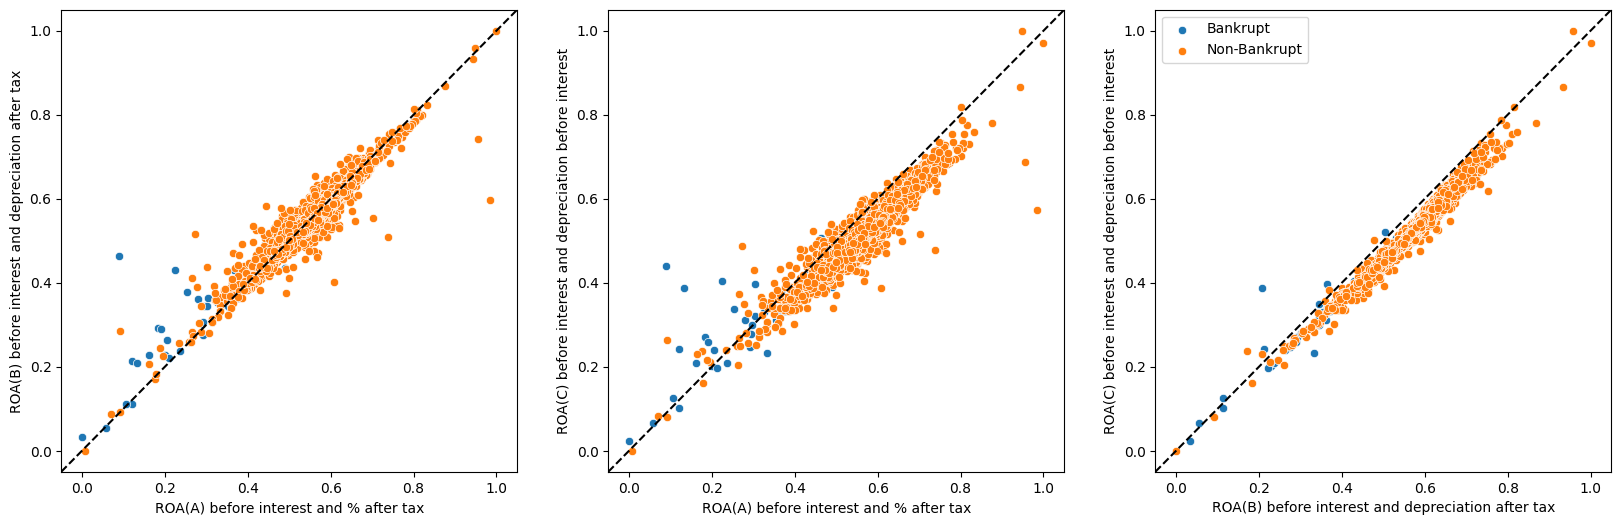

,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,ROA(C) before interest and depreciation before interest,Bankrupt?
ROA(A) before interest and % after tax,1.000000,0.955741,0.940124,-0.282941
ROA(B) before interest and depreciation after tax,0.955741,1.000000,0.986849,-0.273051
ROA(C) before interest and depreciation before interest,0.940124,0.986849,1.000000,-0.260807
Bankrupt?,-0.282941,-0.273051,-0.260807,1.000000


In [11]:
# Scatter plot of ROA(A), ROA(B), ROA(C) of bankrupt and non-bankrupt companies
features = ['ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'ROA(C) before interest and depreciation before interest']
scatterplot(bankrupt, non_bankrupt, features)

# Show the correlation between ROA(A), ROA(B), ROA(C)
correlation_table(dataset, features)

ROA(A), ROA(B), ROA(C) are are similar metrics with a high correlation with each other. ROA(A) has the highest correlation with the target variable, so we will keep this variable and drop the other two during preprocessing.

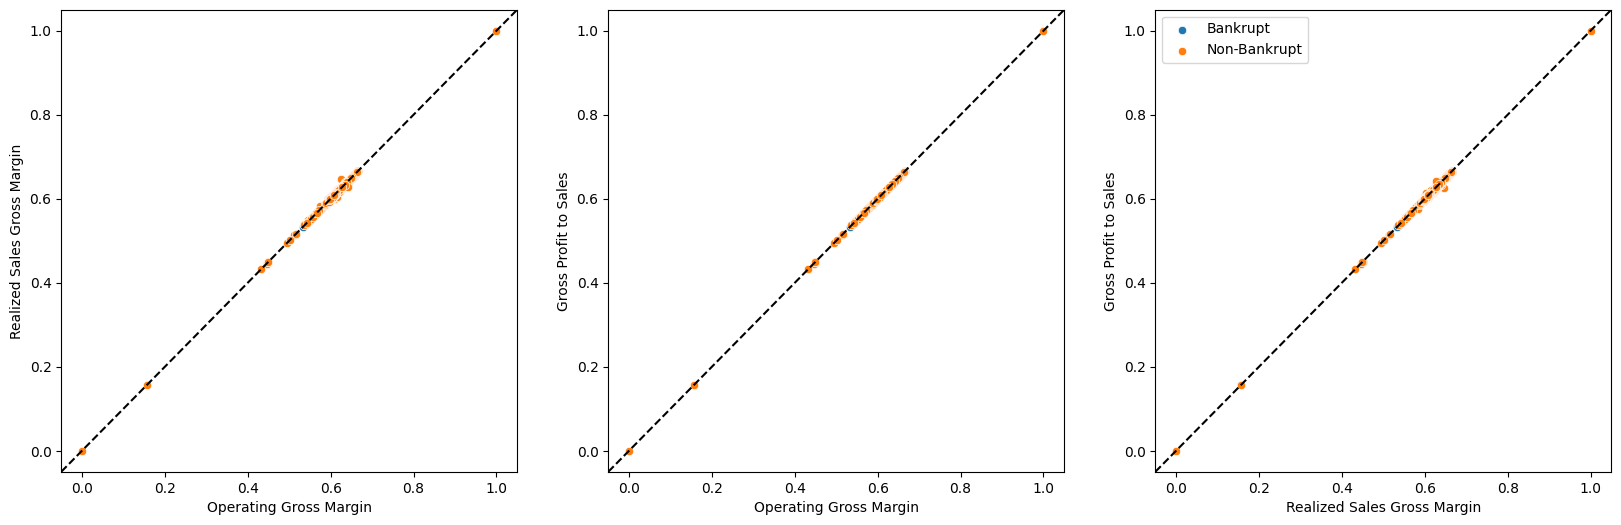

,Operating Gross Margin,Realized Sales Gross Margin,Gross Profit to Sales,Bankrupt?
Operating Gross Margin,1.000000,0.999518,1.000000,-0.100043
Realized Sales Gross Margin,0.999518,1.000000,0.999518,-0.099445
Gross Profit to Sales,1.000000,0.999518,1.000000,-0.100044
Bankrupt?,-0.100043,-0.099445,-0.100044,1.000000


In [12]:
# Group Operating Gross Margin
features = ['Operating Gross Margin', 'Realized Sales Gross Margin', 'Gross Profit to Sales']
scatterplot(bankrupt, non_bankrupt, features)
correlation_table(dataset, features)

We can see that Operating Gross Margin, Realized Gross Profit Margin and Gross Profit to Sales are almost identical with a correlation of almost 1. We will keep Gross Profit to Sales and drop the other two.

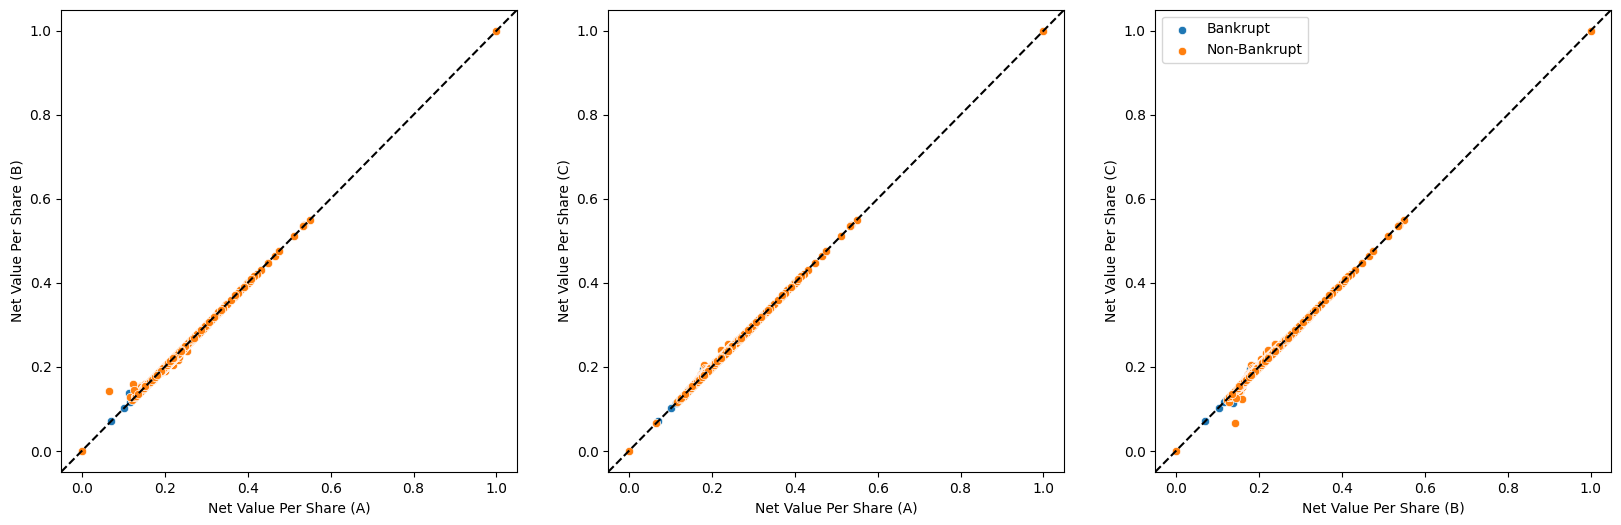

,Net Value Per Share (A),Net Value Per Share (B),Net Value Per Share (C),Bankrupt?
Net Value Per Share (A),1.000000,0.999342,0.999837,-0.165465
Net Value Per Share (B),0.999342,1.000000,0.999179,-0.165399
Net Value Per Share (C),0.999837,0.999179,1.000000,-0.164784
Bankrupt?,-0.165465,-0.165399,-0.164784,1.000000


In [13]:
# Scatter plot of Net Value Per Share (A), Net Value Per Share (B), Net Value Per Share (C) of bankrupt and non-bankrupt companies
features = ['Net Value Per Share (A)', 'Net Value Per Share (B)', 'Net Value Per Share (C)']
scatterplot(bankrupt, non_bankrupt, features)

# Show the correlation between Net Value Per Share (A), Net Value Per Share (B), Net Value Per Share (C)
correlation_table(dataset, features)

Net Value Per Share (A), Net Value Per Share (B), Net Value Per Share (C) are highly correlated. Net Value Per Share (A) has the highest correlation with the target variable, so we will keep this variable and drop the other two during preprocessing.

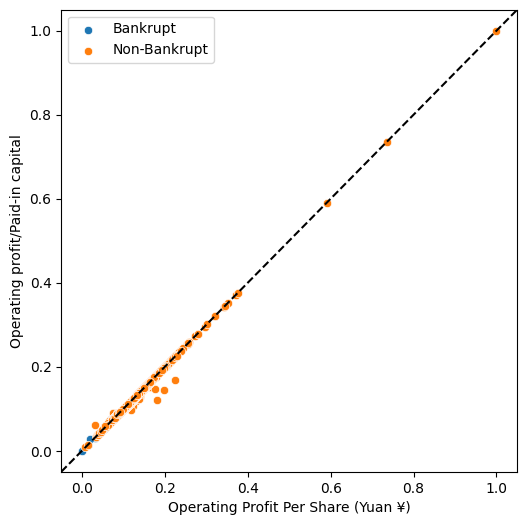

,Operating Profit Per Share (Yuan ¥),Operating profit/Paid-in capital,Bankrupt?
Operating Profit Per Share (Yuan ¥),1.000000,0.998696,-0.142051
Operating profit/Paid-in capital,0.998696,1.000000,-0.141111
Bankrupt?,-0.142051,-0.141111,1.000000


In [14]:
# Operating Profit Per Share (Yuan ¥) vs Operating profit/Paid-in capital
features = ['Operating Profit Per Share (Yuan ¥)', 'Operating profit/Paid-in capital']
scatterplot(bankrupt, non_bankrupt, features)
correlation_table(dataset, features)

As Opearting profit/Paid-in capital is highly correlated with Opearting profit Per Share (Yuan ¥), we will keep Opearting profit Per Share (Yuan ¥) and drop the other one.

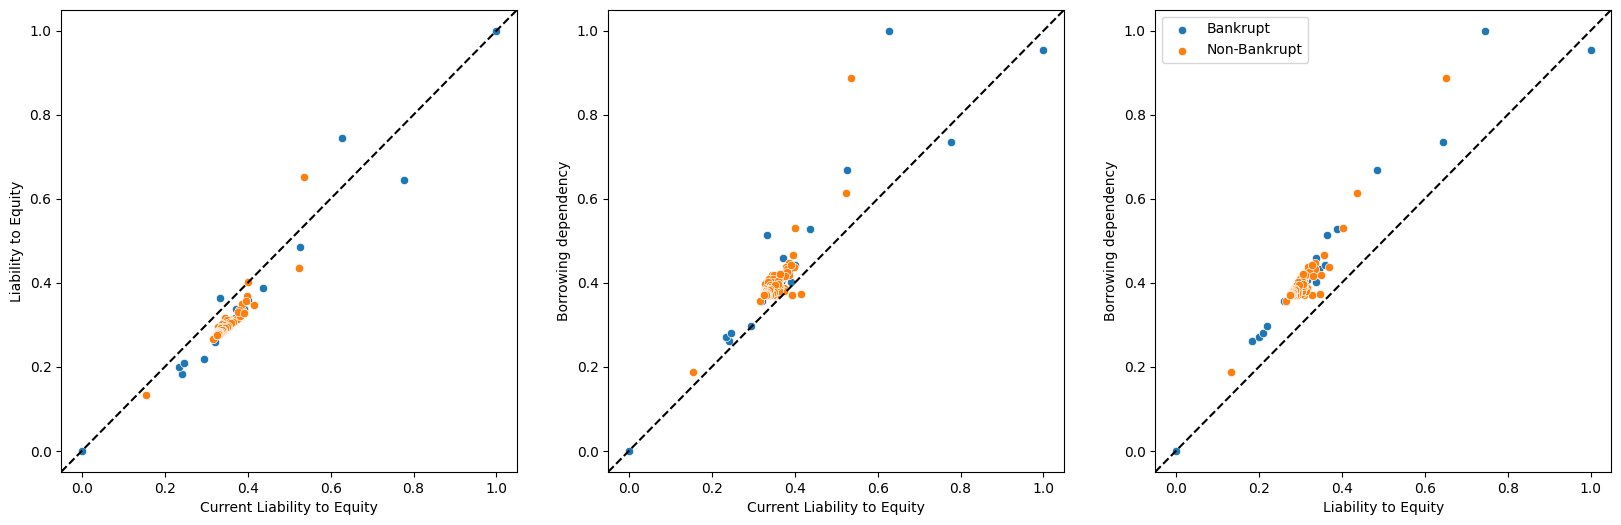

,Current Liability to Equity,Liability to Equity,Borrowing dependency,Bankrupt?
Current Liability to Equity,1.000000,0.963908,0.892772,0.153828
Liability to Equity,0.963908,1.000000,0.955857,0.166812
Borrowing dependency,0.892772,0.955857,1.000000,0.176543
Bankrupt?,0.153828,0.166812,0.176543,1.000000


In [15]:
#Current Liabilities/Equity, Current Liability to Equity, Liability to Equity
features = ['Current Liability to Equity', 'Liability to Equity', 'Borrowing dependency']
scatterplot(bankrupt, non_bankrupt, features)
correlation_table(dataset, features)

Among the 3 variables related to the liability, Liability is highly correlated with the other two. We will drop this variable.

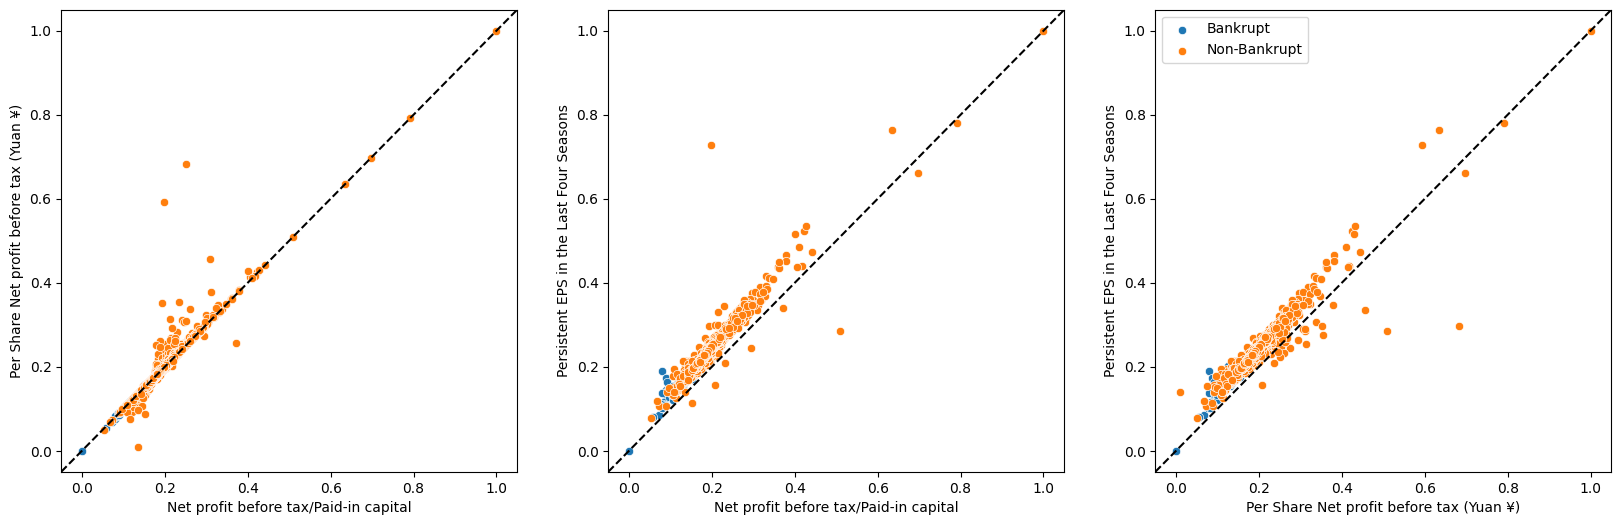

,Net profit before tax/Paid-in capital,Per Share Net profit before tax (Yuan ¥),Persistent EPS in the Last Four Seasons,Bankrupt?
Net profit before tax/Paid-in capital,1.000000,0.962723,0.959461,-0.207857
Per Share Net profit before tax (Yuan ¥),0.962723,1.000000,0.955591,-0.201395
Persistent EPS in the Last Four Seasons,0.959461,0.955591,1.000000,-0.219560
Bankrupt?,-0.207857,-0.201395,-0.219560,1.000000


In [16]:
#Group related to Net profit before tax/Paid-in capital
features = ['Net profit before tax/Paid-in capital','Per Share Net profit before tax (Yuan ¥)','Persistent EPS in the Last Four Seasons']
scatterplot(bankrupt, non_bankrupt, features)
correlation_table(dataset, features)

Among the 3 highly correlated variables related to the cash flow, we will keep Persistent EPS in the Last Four Seasons and drop the other two.

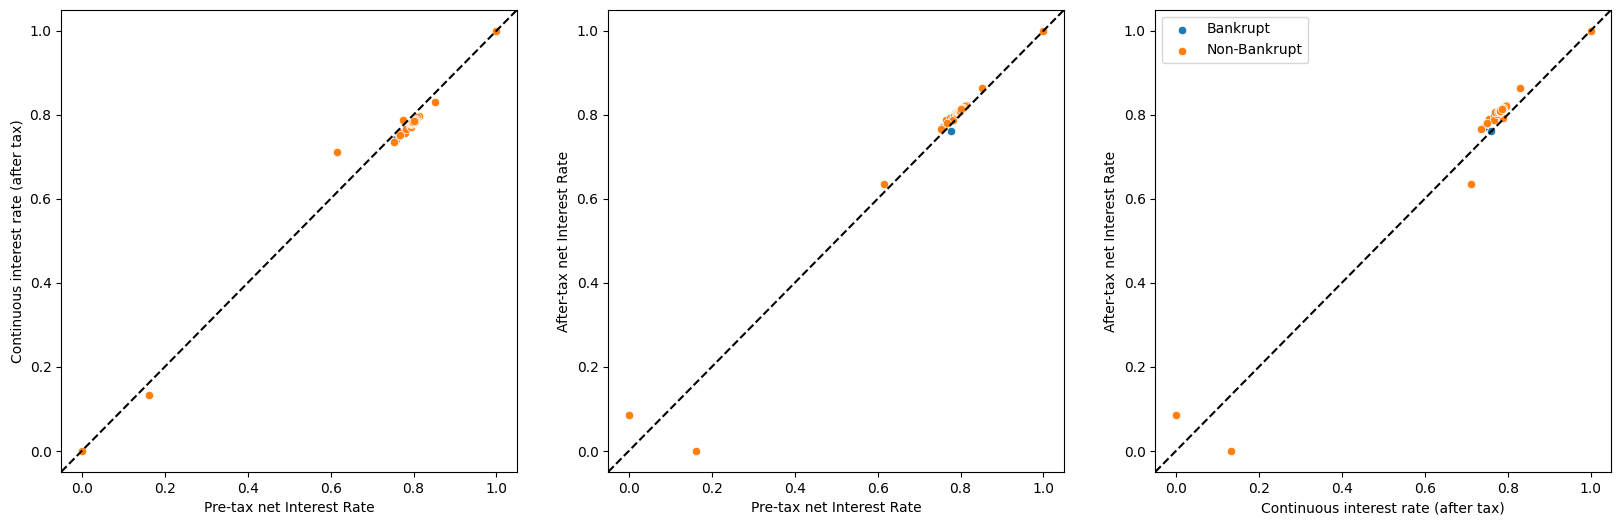

,Pre-tax net Interest Rate,Continuous interest rate (after tax),After-tax net Interest Rate,Bankrupt?
Pre-tax net Interest Rate,1.000000,0.993617,0.986379,-0.008517
Continuous interest rate (after tax),0.993617,1.000000,0.984452,-0.008395
After-tax net Interest Rate,0.986379,0.984452,1.000000,-0.008857
Bankrupt?,-0.008517,-0.008395,-0.008857,1.000000


In [17]:
# Interest rates
features = ['Pre-tax net Interest Rate', 'Continuous interest rate (after tax)', 'After-tax net Interest Rate']
scatterplot(bankrupt, non_bankrupt, features)
correlation_table(dataset, features)

Among the 3 highly correlated variables related to interest rate, we will keep After-tax net Interest Rate and drop the other two.

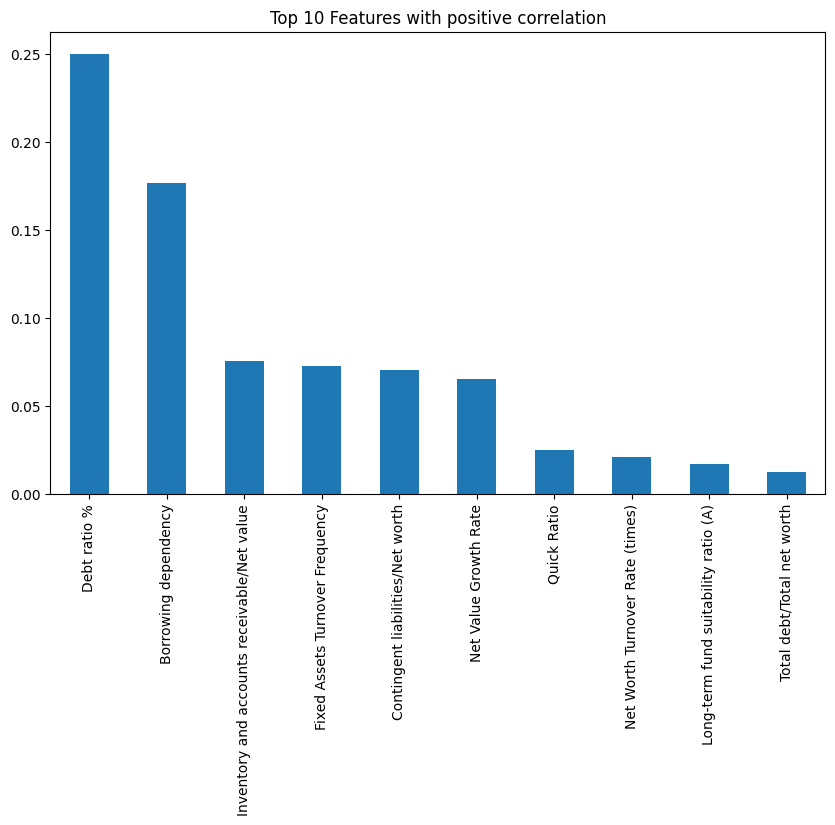

In [18]:
# Plot the correlation of the features with the target variable
variables = dataset.drop(['Bankrupt?'], axis=1)
variables = variables.drop(['Net Income Flag'], axis=1)
variables = variables.drop(['Current Liabilities/Liability'], axis=1)
variables = variables.drop(['Current Liabilities/Equity'], axis=1)
variables = variables.drop(['ROA(B) before interest and depreciation after tax', 'ROA(C) before interest and depreciation before interest'], axis=1)
variables = variables.drop(['Operating Gross Margin','Realized Sales Gross Margin'], axis=1)
variables = variables.drop(['Net Value Per Share (B)','Net Value Per Share (C)'], axis=1)
variables = variables.drop(['Operating profit/Paid-in capital'], axis=1)
variables = variables.drop(['Liability to Equity'], axis=1)
variables = variables.drop(['Net profit before tax/Paid-in capital','Per Share Net profit before tax (Yuan ¥)'], axis=1)
variables = variables.drop(['Continuous interest rate (after tax)', 'After-tax net Interest Rate'], axis=1)
variables.shape
correlations = variables.corrwith(dataset['Bankrupt?'])

# Plot the features with positive correlation
plt.figure(figsize=(10, 6))
correlations[correlations > 0].head(10).sort_values(ascending=False).plot(kind='bar')
plt.title('Top 10 Features with positive correlation')
plt.show()

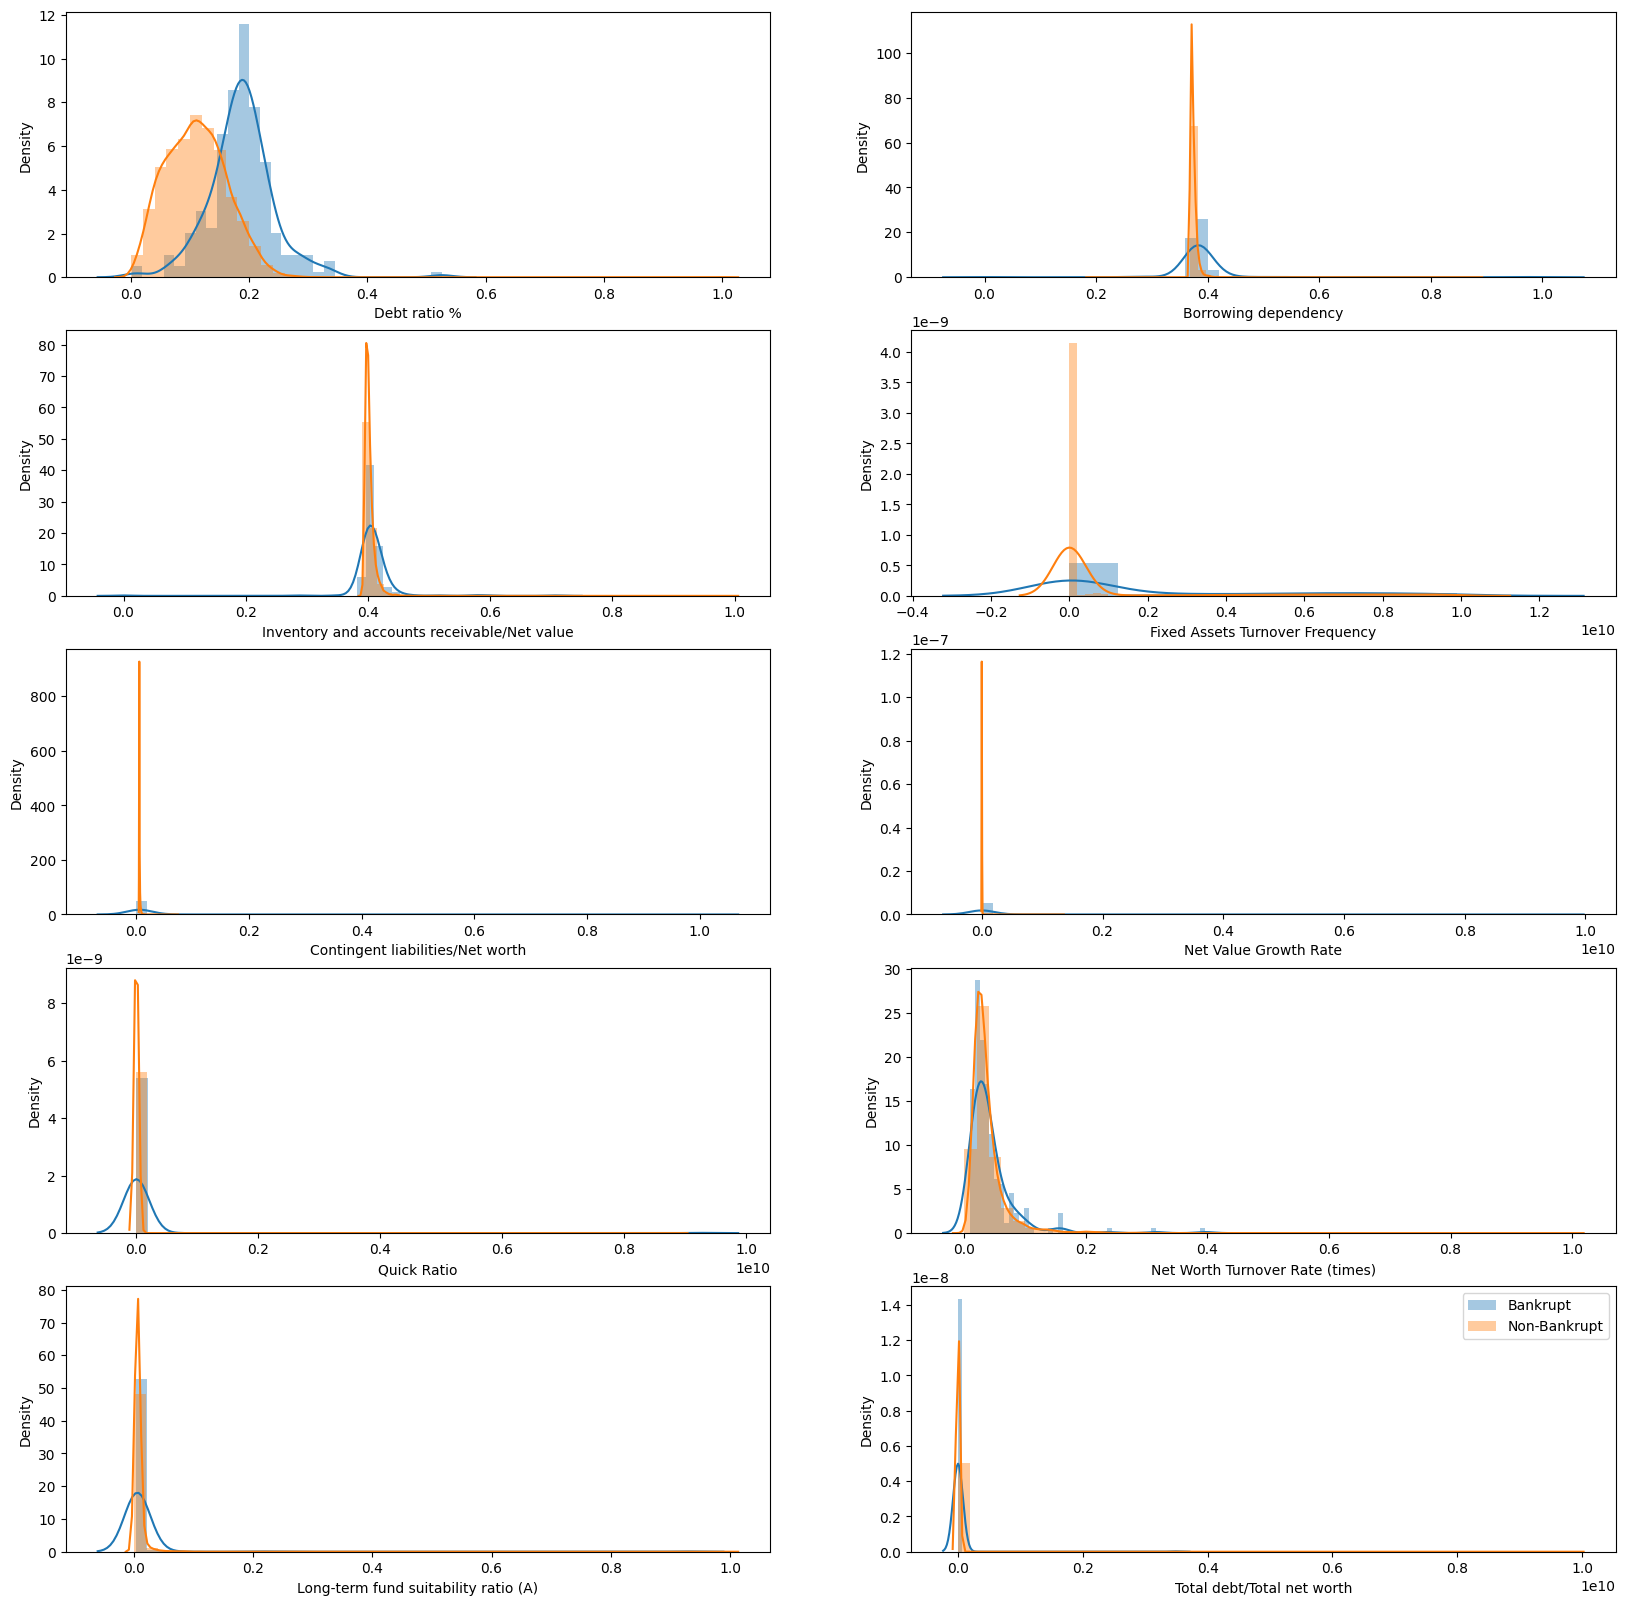

In [19]:
# Plot the distribution of the features with top 10 positive correlation
features = ['Debt ratio %', 'Borrowing dependency',
       'Inventory and accounts receivable/Net value',
       'Fixed Assets Turnover Frequency', 'Contingent liabilities/Net worth',
       'Net Value Growth Rate', 'Quick Ratio',
       'Net Worth Turnover Rate (times)',
       'Long-term fund suitability ratio (A)', 'Total debt/Total net worth']

plt.figure(figsize=(20, 20))
for (i, feature) in enumerate(features):
  plt.subplot(5, 2, i+1)
  sns.distplot(bankrupt[feature], label='Bankrupt')
  sns.distplot(non_bankrupt[feature], label='Non-Bankrupt')

plt.legend()
plt.show()

From the top 10 features with positive correlation with bankruptcy, we can see that features related to liabilities such as "Debt ratio %" and "Borrowing dependency" are important indicators of bankruptcy.

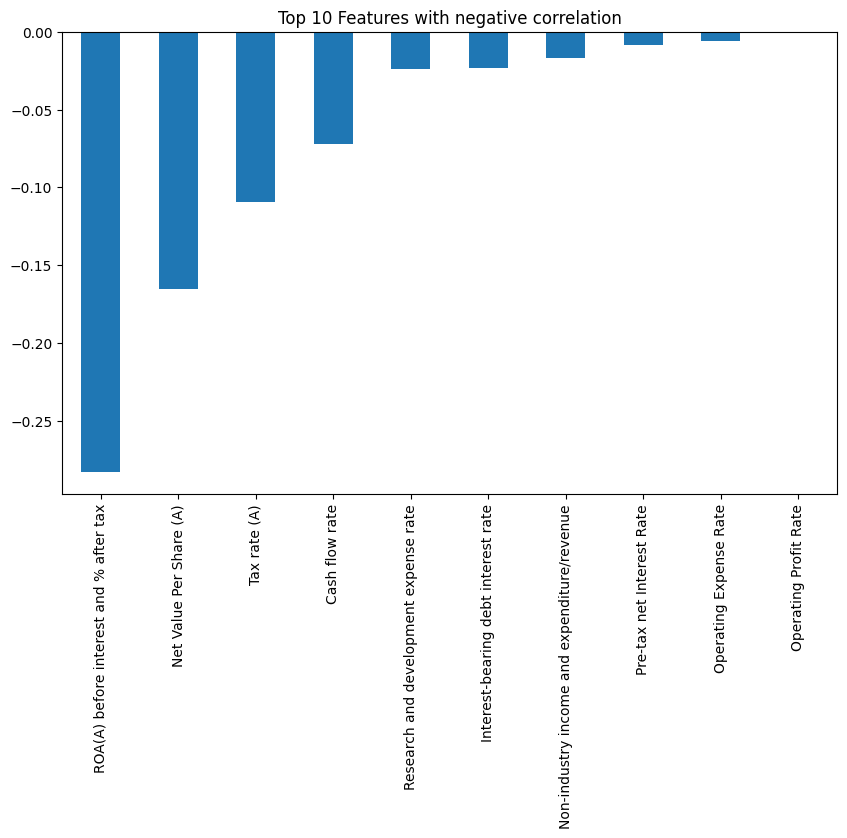

In [20]:
# Plot the features with negative correlation
plt.figure(figsize=(10, 6))
correlations[correlations < 0].head(10).sort_values(ascending=True).plot(kind='bar')
plt.title('Top 10 Features with negative correlation')
plt.show()

Companies with high return on asset and net value per share are less likely to go bankrupt.

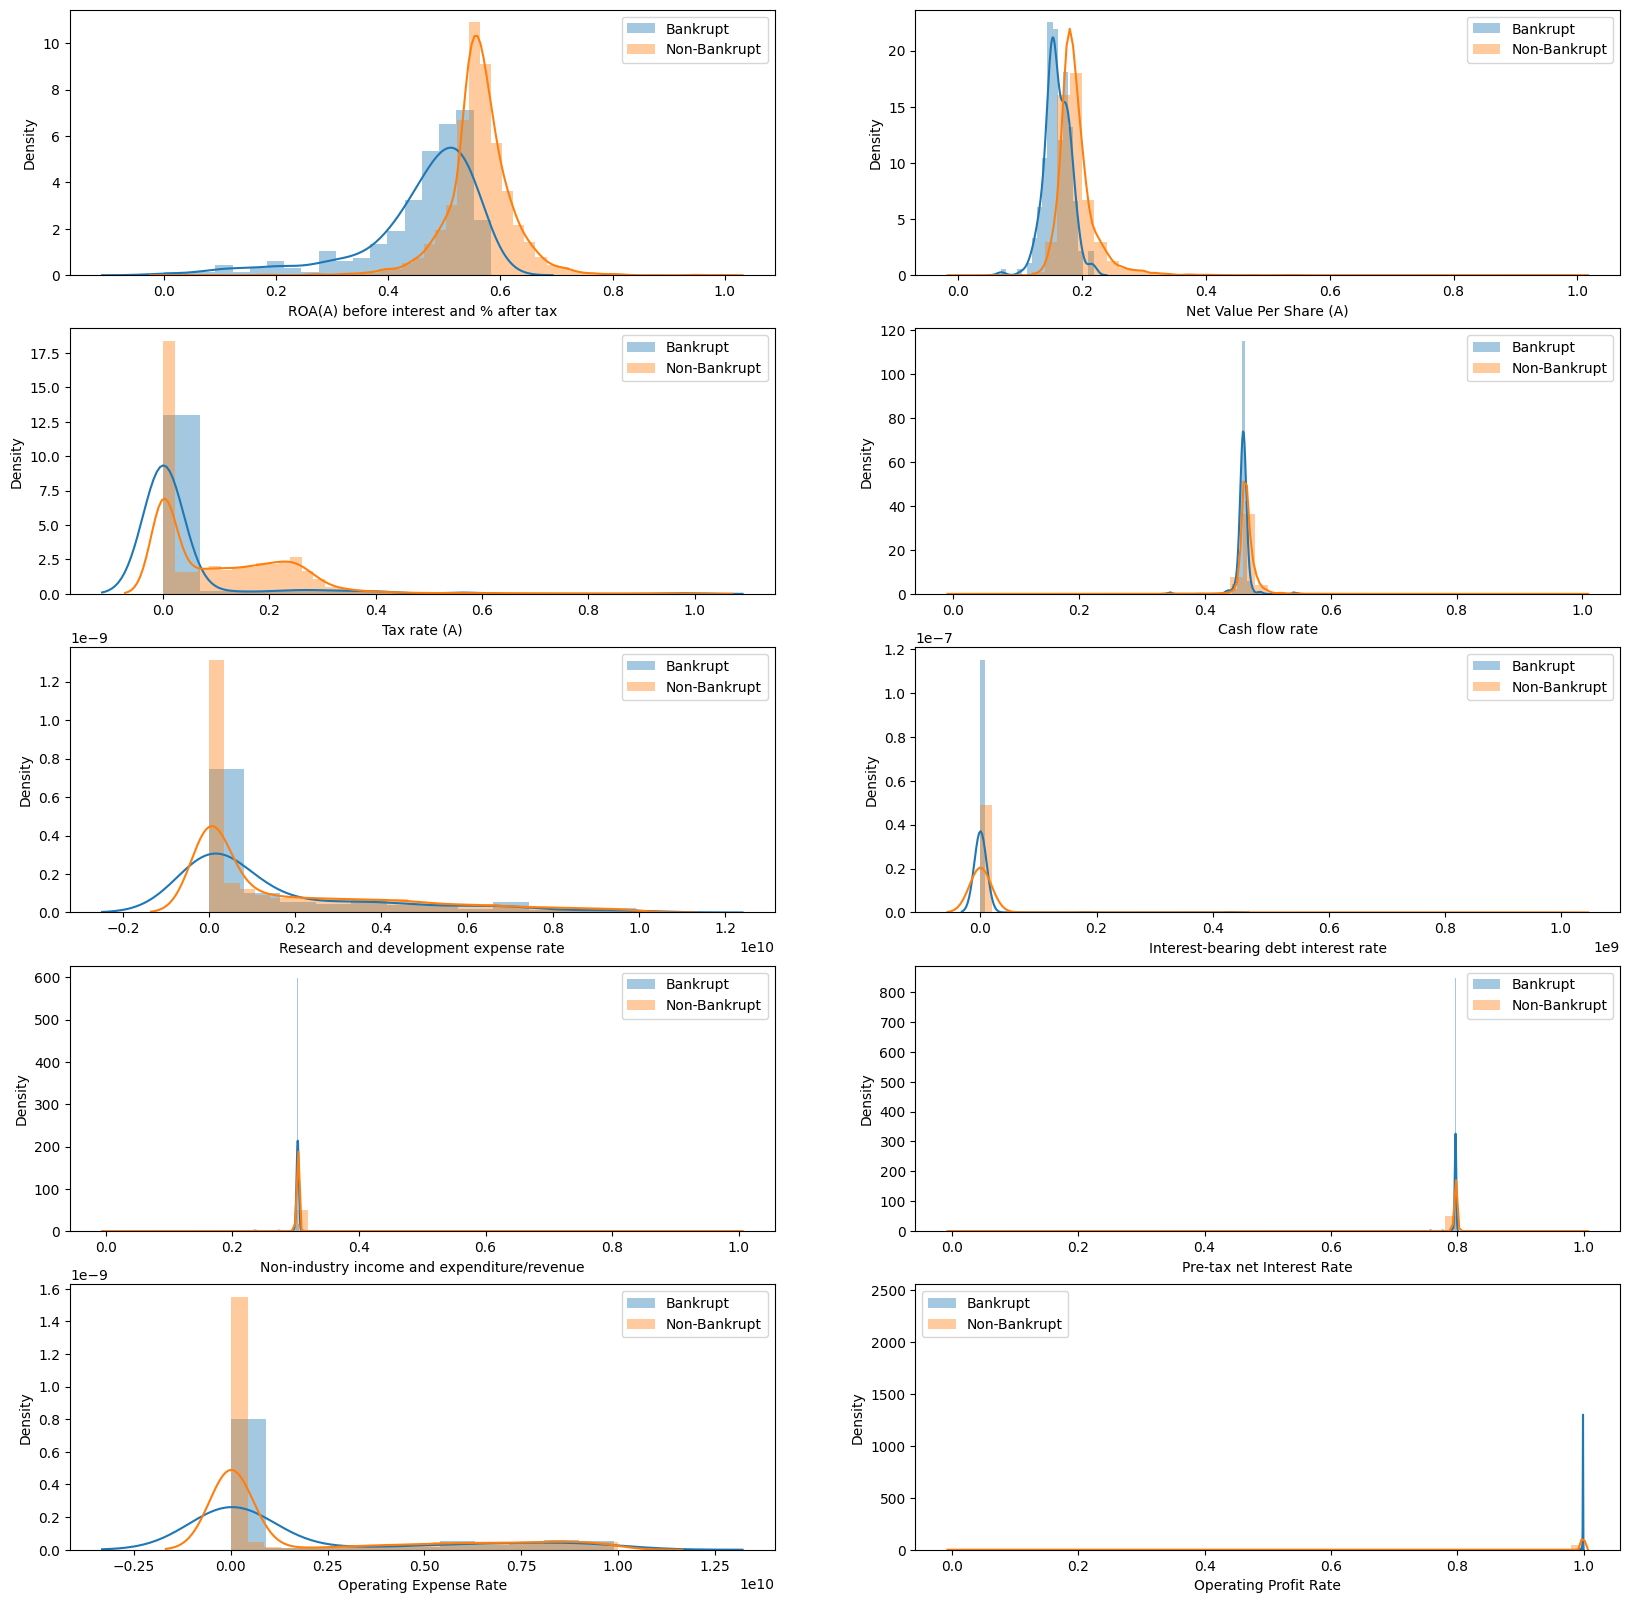

In [21]:
# Plot the distribution of the features with top 10 negative correlation

features = ['ROA(A) before interest and % after tax', 'Net Value Per Share (A)',
       'Tax rate (A)', 'Cash flow rate',
       'Research and development expense rate',
       'Interest-bearing debt interest rate',
       'Non-industry income and expenditure/revenue',
       'Pre-tax net Interest Rate', 'Operating Expense Rate',
       'Operating Profit Rate']

plt.figure(figsize=(20, 20))
for (i, feature) in enumerate(features):
  plt.subplot(5, 2, i+1)
  sns.distplot(bankrupt[feature], label='Bankrupt')
  sns.distplot(non_bankrupt[feature], label='Non-Bankrupt')
  plt.legend()

plt.show()

Features related to income and assets show that the higher the income and assets, the lower the risk of bankruptcy.

The performance of XGBoost with Randomized Search is better with higher Precision, Recall and F1 score.